# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import modelPool
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 3e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

CLASS_WEIGHTS = [2.45780159e-01, 2.24610010e-01, 2.24005501e-01, 1.87119512e-02,
 1.46965911e-01, 2.54698498e-02, 2.35562466e-02, 4.28713053e-03,
 3.93593665e-04, 1.38500705e-02, 6.78984614e-02, 1.01436955e-04,
 4.36967906e-03]

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelPool.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.DiceLoss(class_weights=CLASS_WEIGHTS).cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = math.ceil(len(trainDS) / BATCH_SIZE)
testSteps = math.ceil(len(testDS) / BATCH_SIZE)
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformerpool_diceLoss.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 1/100
Train loss: 0.949558, Test loss: 0.9415, Train IoU: 0.5471, Test IoU: 0.6647, Train Dice: 0.6967, Test Dice: 0.7983
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 2/100
Train loss: 0.939365, Test loss: 0.9368, Train IoU: 0.6998, Test IoU: 0.7469, Train Dice: 0.8230, Test Dice: 0.8550
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:47<00:00,  1.89it/s]


[INFO] EPOCH: 3/100
Train loss: 0.936408, Test loss: 0.9353, Train IoU: 0.7471, Test IoU: 0.7686, Train Dice: 0.8551, Test Dice: 0.8690
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 4/100
Train loss: 0.934983, Test loss: 0.9342, Train IoU: 0.7702, Test IoU: 0.7822, Train Dice: 0.8700, Test Dice: 0.8777
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 5/100
Train loss: 0.933744, Test loss: 0.9330, Train IoU: 0.7879, Test IoU: 0.8000, Train Dice: 0.8812, Test Dice: 0.8888
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 6/100
Train loss: 0.932589, Test loss: 0.9317, Train IoU: 0.8059, Test IoU: 0.8241, Train Dice: 0.8924, Test Dice: 0.9035
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.91it/s]


[INFO] EPOCH: 7/100
Train loss: 0.931668, Test loss: 0.9310, Train IoU: 0.8226, Test IoU: 0.8353, Train Dice: 0.9026, Test Dice: 0.9102
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 8/100
Train loss: 0.931090, Test loss: 0.9304, Train IoU: 0.8324, Test IoU: 0.8478, Train Dice: 0.9084, Test Dice: 0.9176
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 9/100
Train loss: 0.930623, Test loss: 0.9302, Train IoU: 0.8414, Test IoU: 0.8532, Train Dice: 0.9138, Test Dice: 0.9207
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 10/100
Train loss: 0.930200, Test loss: 0.9297, Train IoU: 0.8493, Test IoU: 0.8599, Train Dice: 0.9184, Test Dice: 0.9246
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 11/100
Train loss: 0.929815, Test loss: 0.9293, Train IoU: 0.8569, Test IoU: 0.8681, Train Dice: 0.9229, Test Dice: 0.9293
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 12/100
Train loss: 0.929568, Test loss: 0.9291, Train IoU: 0.8614, Test IoU: 0.8716, Train Dice: 0.9255, Test Dice: 0.9314
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 13/100
Train loss: 0.929310, Test loss: 0.9288, Train IoU: 0.8668, Test IoU: 0.8772, Train Dice: 0.9286, Test Dice: 0.9345
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 14/100
Train loss: 0.929151, Test loss: 0.9289, Train IoU: 0.8696, Test IoU: 0.8753, Train Dice: 0.9302, Test Dice: 0.9334


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 15/100
Train loss: 0.928883, Test loss: 0.9284, Train IoU: 0.8748, Test IoU: 0.8853, Train Dice: 0.9332, Test Dice: 0.9391
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 16/100
Train loss: 0.928675, Test loss: 0.9284, Train IoU: 0.8794, Test IoU: 0.8853, Train Dice: 0.9358, Test Dice: 0.9391


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 17/100
Train loss: 0.928574, Test loss: 0.9284, Train IoU: 0.8816, Test IoU: 0.8866, Train Dice: 0.9370, Test Dice: 0.9399
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 18/100
Train loss: 0.928423, Test loss: 0.9282, Train IoU: 0.8847, Test IoU: 0.8888, Train Dice: 0.9387, Test Dice: 0.9411
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 19/100
Train loss: 0.928282, Test loss: 0.9281, Train IoU: 0.8876, Test IoU: 0.8922, Train Dice: 0.9404, Test Dice: 0.9430
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:48<00:00,  1.85it/s]


[INFO] EPOCH: 20/100
Train loss: 0.928143, Test loss: 0.9279, Train IoU: 0.8905, Test IoU: 0.8958, Train Dice: 0.9420, Test Dice: 0.9450
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 21/100
Train loss: 0.928194, Test loss: 0.9281, Train IoU: 0.8898, Test IoU: 0.8912, Train Dice: 0.9416, Test Dice: 0.9424


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 22/100
Train loss: 0.928040, Test loss: 0.9278, Train IoU: 0.8922, Test IoU: 0.8991, Train Dice: 0.9429, Test Dice: 0.9468
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 23/100
Train loss: 0.927823, Test loss: 0.9276, Train IoU: 0.8971, Test IoU: 0.9012, Train Dice: 0.9457, Test Dice: 0.9480
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 24/100
Train loss: 0.929150, Test loss: 0.9279, Train IoU: 0.8702, Test IoU: 0.8946, Train Dice: 0.9303, Test Dice: 0.9443


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 25/100
Train loss: 0.927907, Test loss: 0.9274, Train IoU: 0.8947, Test IoU: 0.9049, Train Dice: 0.9444, Test Dice: 0.9501
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 26/100
Train loss: 0.927725, Test loss: 0.9274, Train IoU: 0.8988, Test IoU: 0.9059, Train Dice: 0.9466, Test Dice: 0.9506
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 27/100
Train loss: 0.927624, Test loss: 0.9278, Train IoU: 0.9013, Test IoU: 0.8971, Train Dice: 0.9480, Test Dice: 0.9457


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 28/100
Train loss: 0.928774, Test loss: 0.9279, Train IoU: 0.8771, Test IoU: 0.8945, Train Dice: 0.9342, Test Dice: 0.9443


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 29/100
Train loss: 0.927797, Test loss: 0.9274, Train IoU: 0.8973, Test IoU: 0.9060, Train Dice: 0.9458, Test Dice: 0.9507
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 30/100
Train loss: 0.927427, Test loss: 0.9272, Train IoU: 0.9053, Test IoU: 0.9109, Train Dice: 0.9502, Test Dice: 0.9533
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 31/100
Train loss: 0.927261, Test loss: 0.9271, Train IoU: 0.9087, Test IoU: 0.9116, Train Dice: 0.9521, Test Dice: 0.9537
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 32/100
Train loss: 0.927705, Test loss: 0.9273, Train IoU: 0.8988, Test IoU: 0.9087, Train Dice: 0.9466, Test Dice: 0.9521


100%|██████████| 202/202 [01:48<00:00,  1.85it/s]


[INFO] EPOCH: 33/100
Train loss: 0.927284, Test loss: 0.9272, Train IoU: 0.9083, Test IoU: 0.9097, Train Dice: 0.9519, Test Dice: 0.9527


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 34/100
Train loss: 0.927237, Test loss: 0.9269, Train IoU: 0.9090, Test IoU: 0.9150, Train Dice: 0.9523, Test Dice: 0.9556
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 35/100
Train loss: 0.927420, Test loss: 0.9270, Train IoU: 0.9049, Test IoU: 0.9139, Train Dice: 0.9500, Test Dice: 0.9550


100%|██████████| 202/202 [01:44<00:00,  1.92it/s]


[INFO] EPOCH: 36/100
Train loss: 0.927103, Test loss: 0.9269, Train IoU: 0.9121, Test IoU: 0.9177, Train Dice: 0.9540, Test Dice: 0.9570
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 37/100
Train loss: 0.927429, Test loss: 0.9269, Train IoU: 0.9047, Test IoU: 0.9157, Train Dice: 0.9499, Test Dice: 0.9559


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 38/100
Train loss: 0.928875, Test loss: 0.9279, Train IoU: 0.8758, Test IoU: 0.8945, Train Dice: 0.9331, Test Dice: 0.9443


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 39/100
Train loss: 0.927505, Test loss: 0.9271, Train IoU: 0.9035, Test IoU: 0.9120, Train Dice: 0.9492, Test Dice: 0.9540


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 40/100
Train loss: 0.927237, Test loss: 0.9269, Train IoU: 0.9089, Test IoU: 0.9173, Train Dice: 0.9522, Test Dice: 0.9569


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 41/100
Train loss: 0.926950, Test loss: 0.9267, Train IoU: 0.9151, Test IoU: 0.9207, Train Dice: 0.9556, Test Dice: 0.9587
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 42/100
Train loss: 0.926875, Test loss: 0.9272, Train IoU: 0.9167, Test IoU: 0.9095, Train Dice: 0.9565, Test Dice: 0.9526


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 43/100
Train loss: 0.928236, Test loss: 0.9273, Train IoU: 0.8883, Test IoU: 0.9076, Train Dice: 0.9403, Test Dice: 0.9515


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 44/100
Train loss: 0.927243, Test loss: 0.9271, Train IoU: 0.9089, Test IoU: 0.9107, Train Dice: 0.9522, Test Dice: 0.9533


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 45/100
Train loss: 0.927019, Test loss: 0.9269, Train IoU: 0.9138, Test IoU: 0.9170, Train Dice: 0.9549, Test Dice: 0.9567


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 46/100
Train loss: 0.927469, Test loss: 0.9273, Train IoU: 0.9030, Test IoU: 0.9057, Train Dice: 0.9489, Test Dice: 0.9505


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 47/100
Train loss: 0.929098, Test loss: 0.9303, Train IoU: 0.8710, Test IoU: 0.8463, Train Dice: 0.9303, Test Dice: 0.9167


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 48/100
Train loss: 0.928297, Test loss: 0.9275, Train IoU: 0.8851, Test IoU: 0.9037, Train Dice: 0.9389, Test Dice: 0.9494


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 49/100
Train loss: 0.927433, Test loss: 0.9277, Train IoU: 0.9035, Test IoU: 0.8976, Train Dice: 0.9492, Test Dice: 0.9460


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 50/100
Train loss: 0.927341, Test loss: 0.9272, Train IoU: 0.9048, Test IoU: 0.9086, Train Dice: 0.9500, Test Dice: 0.9521


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 51/100
Train loss: 0.927181, Test loss: 0.9272, Train IoU: 0.9087, Test IoU: 0.9084, Train Dice: 0.9521, Test Dice: 0.9520


100%|██████████| 202/202 [01:44<00:00,  1.93it/s]


[INFO] EPOCH: 52/100
Train loss: 0.927031, Test loss: 0.9270, Train IoU: 0.9120, Test IoU: 0.9137, Train Dice: 0.9539, Test Dice: 0.9549


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 53/100
Train loss: 0.928211, Test loss: 0.9274, Train IoU: 0.8866, Test IoU: 0.9050, Train Dice: 0.9397, Test Dice: 0.9501


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 54/100
Train loss: 0.927251, Test loss: 0.9289, Train IoU: 0.9072, Test IoU: 0.8733, Train Dice: 0.9513, Test Dice: 0.9323


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 55/100
Train loss: 0.927387, Test loss: 0.9272, Train IoU: 0.9042, Test IoU: 0.9102, Train Dice: 0.9496, Test Dice: 0.9529


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 56/100
Train loss: 0.926939, Test loss: 0.9269, Train IoU: 0.9134, Test IoU: 0.9154, Train Dice: 0.9547, Test Dice: 0.9558


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 57/100
Train loss: 0.929244, Test loss: 0.9276, Train IoU: 0.8656, Test IoU: 0.8998, Train Dice: 0.9271, Test Dice: 0.9472


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 58/100
Train loss: 0.927284, Test loss: 0.9272, Train IoU: 0.9064, Test IoU: 0.9093, Train Dice: 0.9509, Test Dice: 0.9525


100%|██████████| 202/202 [01:51<00:00,  1.82it/s]


[INFO] EPOCH: 59/100
Train loss: 0.926982, Test loss: 0.9270, Train IoU: 0.9126, Test IoU: 0.9144, Train Dice: 0.9543, Test Dice: 0.9552


100%|██████████| 202/202 [01:50<00:00,  1.82it/s]


[INFO] EPOCH: 60/100
Train loss: 0.926874, Test loss: 0.9269, Train IoU: 0.9153, Test IoU: 0.9148, Train Dice: 0.9557, Test Dice: 0.9555


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 61/100
Train loss: 0.926814, Test loss: 0.9268, Train IoU: 0.9165, Test IoU: 0.9180, Train Dice: 0.9564, Test Dice: 0.9572


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 62/100
Train loss: 0.926694, Test loss: 0.9267, Train IoU: 0.9190, Test IoU: 0.9191, Train Dice: 0.9577, Test Dice: 0.9578


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 63/100
Train loss: 0.926699, Test loss: 0.9268, Train IoU: 0.9193, Test IoU: 0.9188, Train Dice: 0.9579, Test Dice: 0.9577


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 64/100
Train loss: 0.926630, Test loss: 0.9267, Train IoU: 0.9205, Test IoU: 0.9207, Train Dice: 0.9585, Test Dice: 0.9587
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 65/100
Train loss: 0.926569, Test loss: 0.9266, Train IoU: 0.9223, Test IoU: 0.9215, Train Dice: 0.9595, Test Dice: 0.9591
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 66/100
Train loss: 0.926563, Test loss: 0.9266, Train IoU: 0.9226, Test IoU: 0.9221, Train Dice: 0.9596, Test Dice: 0.9594
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 67/100
Train loss: 0.926523, Test loss: 0.9265, Train IoU: 0.9232, Test IoU: 0.9237, Train Dice: 0.9600, Test Dice: 0.9603
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 68/100
Train loss: 0.926479, Test loss: 0.9266, Train IoU: 0.9241, Test IoU: 0.9226, Train Dice: 0.9605, Test Dice: 0.9597


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 69/100
Train loss: 0.926428, Test loss: 0.9265, Train IoU: 0.9254, Test IoU: 0.9245, Train Dice: 0.9611, Test Dice: 0.9607
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 70/100
Train loss: 0.926363, Test loss: 0.9264, Train IoU: 0.9266, Test IoU: 0.9258, Train Dice: 0.9618, Test Dice: 0.9614
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 71/100
Train loss: 0.926335, Test loss: 0.9265, Train IoU: 0.9270, Test IoU: 0.9248, Train Dice: 0.9620, Test Dice: 0.9608


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 72/100
Train loss: 0.926351, Test loss: 0.9264, Train IoU: 0.9267, Test IoU: 0.9273, Train Dice: 0.9618, Test Dice: 0.9622
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 73/100
Train loss: 0.926290, Test loss: 0.9264, Train IoU: 0.9285, Test IoU: 0.9270, Train Dice: 0.9627, Test Dice: 0.9621


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 74/100
Train loss: 0.926308, Test loss: 0.9263, Train IoU: 0.9278, Test IoU: 0.9276, Train Dice: 0.9623, Test Dice: 0.9624
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 75/100
Train loss: 0.926215, Test loss: 0.9263, Train IoU: 0.9296, Test IoU: 0.9291, Train Dice: 0.9633, Test Dice: 0.9632
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 76/100
Train loss: 0.926183, Test loss: 0.9263, Train IoU: 0.9301, Test IoU: 0.9281, Train Dice: 0.9635, Test Dice: 0.9626


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 77/100
Train loss: 0.926193, Test loss: 0.9264, Train IoU: 0.9301, Test IoU: 0.9253, Train Dice: 0.9635, Test Dice: 0.9611


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 78/100
Train loss: 0.926235, Test loss: 0.9263, Train IoU: 0.9296, Test IoU: 0.9290, Train Dice: 0.9632, Test Dice: 0.9631


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 79/100
Train loss: 0.926126, Test loss: 0.9262, Train IoU: 0.9317, Test IoU: 0.9298, Train Dice: 0.9644, Test Dice: 0.9635
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 80/100
Train loss: 0.926127, Test loss: 0.9263, Train IoU: 0.9315, Test IoU: 0.9286, Train Dice: 0.9642, Test Dice: 0.9629


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 81/100
Train loss: 0.926121, Test loss: 0.9262, Train IoU: 0.9320, Test IoU: 0.9308, Train Dice: 0.9645, Test Dice: 0.9641
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 82/100
Train loss: 0.926103, Test loss: 0.9262, Train IoU: 0.9322, Test IoU: 0.9315, Train Dice: 0.9646, Test Dice: 0.9644
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 83/100
Train loss: 0.926078, Test loss: 0.9262, Train IoU: 0.9327, Test IoU: 0.9309, Train Dice: 0.9648, Test Dice: 0.9641


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 84/100
Train loss: 0.926056, Test loss: 0.9262, Train IoU: 0.9334, Test IoU: 0.9309, Train Dice: 0.9652, Test Dice: 0.9641


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 85/100
Train loss: 0.926056, Test loss: 0.9261, Train IoU: 0.9331, Test IoU: 0.9322, Train Dice: 0.9650, Test Dice: 0.9648
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 86/100
Train loss: 0.926038, Test loss: 0.9262, Train IoU: 0.9337, Test IoU: 0.9313, Train Dice: 0.9653, Test Dice: 0.9643


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 87/100
Train loss: 0.926033, Test loss: 0.9261, Train IoU: 0.9340, Test IoU: 0.9323, Train Dice: 0.9655, Test Dice: 0.9649
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 88/100
Train loss: 0.926014, Test loss: 0.9261, Train IoU: 0.9341, Test IoU: 0.9321, Train Dice: 0.9656, Test Dice: 0.9647


100%|██████████| 202/202 [01:47<00:00,  1.89it/s]


[INFO] EPOCH: 89/100
Train loss: 0.926015, Test loss: 0.9261, Train IoU: 0.9345, Test IoU: 0.9322, Train Dice: 0.9658, Test Dice: 0.9648


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 90/100
Train loss: 0.926559, Test loss: 0.9263, Train IoU: 0.9226, Test IoU: 0.9277, Train Dice: 0.9593, Test Dice: 0.9624


100%|██████████| 202/202 [01:45<00:00,  1.92it/s]


[INFO] EPOCH: 91/100
Train loss: 0.926088, Test loss: 0.9261, Train IoU: 0.9330, Test IoU: 0.9322, Train Dice: 0.9650, Test Dice: 0.9648


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 92/100
Train loss: 0.925970, Test loss: 0.9261, Train IoU: 0.9353, Test IoU: 0.9337, Train Dice: 0.9662, Test Dice: 0.9656
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:45<00:00,  1.91it/s]


[INFO] EPOCH: 93/100
Train loss: 0.925910, Test loss: 0.9260, Train IoU: 0.9369, Test IoU: 0.9345, Train Dice: 0.9671, Test Dice: 0.9660
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 94/100
Train loss: 0.925897, Test loss: 0.9260, Train IoU: 0.9370, Test IoU: 0.9337, Train Dice: 0.9671, Test Dice: 0.9656


100%|██████████| 202/202 [01:46<00:00,  1.91it/s]


[INFO] EPOCH: 95/100
Train loss: 0.925864, Test loss: 0.9260, Train IoU: 0.9374, Test IoU: 0.9340, Train Dice: 0.9673, Test Dice: 0.9657


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 96/100
Train loss: 0.925855, Test loss: 0.9260, Train IoU: 0.9380, Test IoU: 0.9358, Train Dice: 0.9676, Test Dice: 0.9667
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 97/100
Train loss: 0.925891, Test loss: 0.9260, Train IoU: 0.9372, Test IoU: 0.9355, Train Dice: 0.9672, Test Dice: 0.9665


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 98/100
Train loss: 0.925897, Test loss: 0.9260, Train IoU: 0.9368, Test IoU: 0.9346, Train Dice: 0.9670, Test Dice: 0.9661


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 99/100
Train loss: 0.925879, Test loss: 0.9260, Train IoU: 0.9372, Test IoU: 0.9353, Train Dice: 0.9672, Test Dice: 0.9664


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 100/100
Train loss: 0.925832, Test loss: 0.9260, Train IoU: 0.9382, Test IoU: 0.9354, Train Dice: 0.9677, Test Dice: 0.9665
[INFO] total time taken to train the model: 12907.02s
Best IoU is: 0.93581


In [13]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformerpool_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

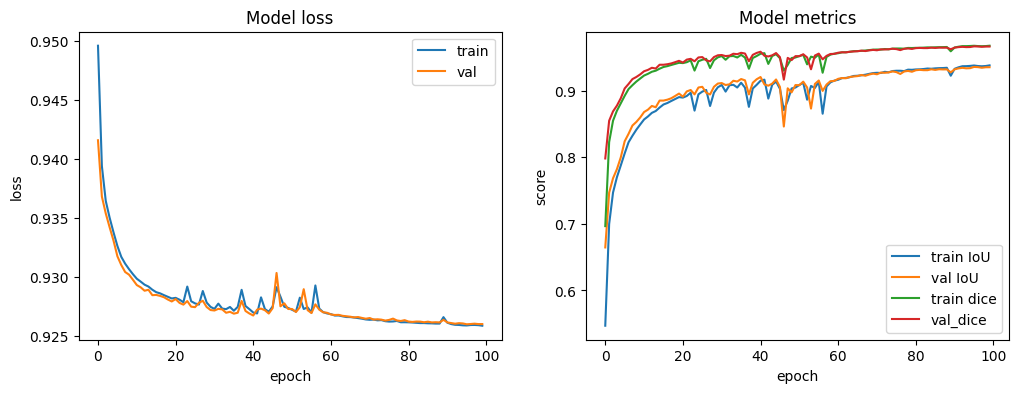

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

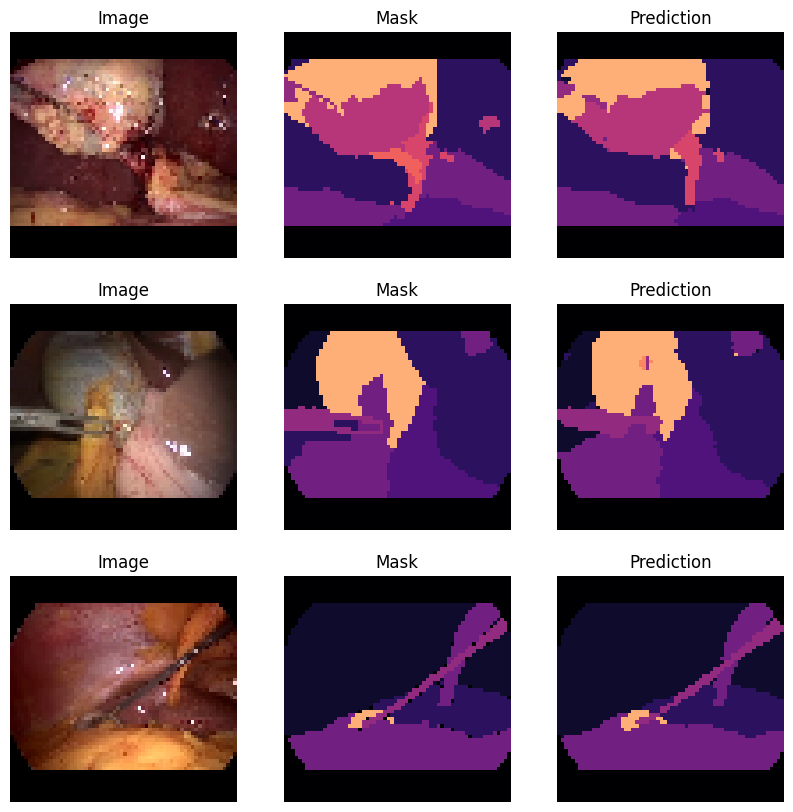

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota